# Feature Engineering

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




In [3]:
import csv
import numpy as np

from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from sklearn import svm
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
import pandas as pd
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

plt.savefig('aicbic_spherical.png')

In [4]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

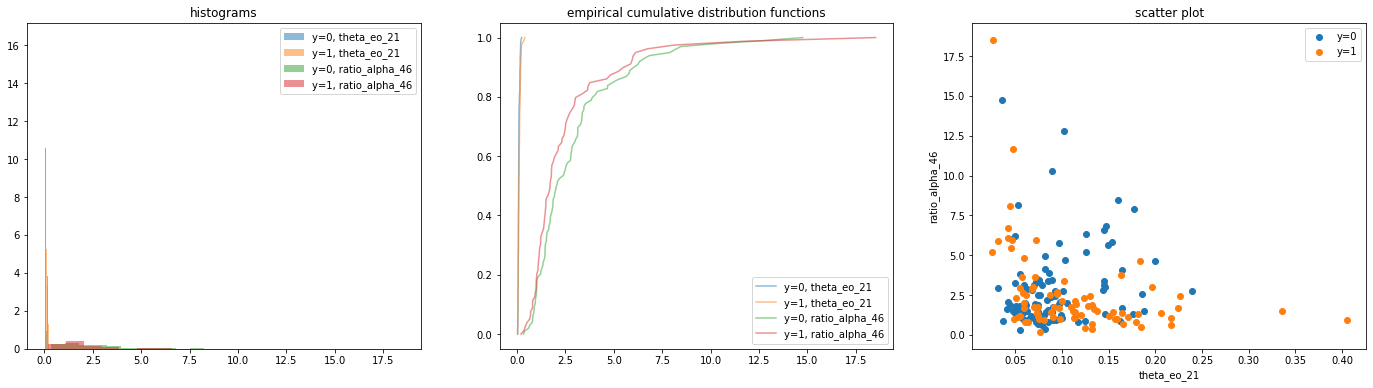

In [33]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

In [8]:
#leave one out method split the 180 observations to 18 groups
group = []
for i in range(18):
    for j in range(10):
        group.append(i)
group = np.array(group)

logo = LeaveOneGroupOut()

def Logo(X, y, model):
    group = []
    for i in range(18):
        for j in range(10):
            group.append(i)
    group = np.array(group)
    my_cv = logo.split(X, y, groups=group)
    meanscore = cross_val_score(model, X, y, cv=my_cv).mean() 
    #meanscore1 = cross_val_score(model, X, y, cv=my_cv,scoring="precision").mean() 
    return meanscore

def Logostd(X, y, model):
    #logo = LeaveOneGroupOut()
    group = []
    for i in range(18):
        for j in range(10):
            group.append(i)
    group = np.array(group)
    my_cv = logo.split(X, y, groups=group)
    stdscore = np.std(cross_val_score(model, X, y, cv=my_cv), ddof=1)
    return stdscore

__filter chi-square__

_1.chi and SVC_

0.9166666666666666 340


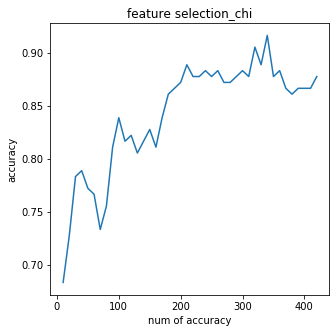

In [151]:
mean_chi = []
std_chi = []
features = range(10,430,10)
for i in features:
    X_fschi = SelectKBest(chi2, k=i).fit_transform(X, y)
    logo = LeaveOneGroupOut()
    for train, test in logo.split(X_fschi, y, groups=group):
        X_train, X_test = X_fschi[train], X_fschi[test]
        y_train, y_test = y[train], y[test]
        clf_svcl = SVC(kernel='linear').fit(X_train, y_train)
    score = Logo(X_fschi, y, clf_svcl)
    std = Logostd(X_fschi, y, clf_svcl)  
    mean_chi.append(score)
    std_chi.append(std)

fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(1,1,1)
ax.set_title("feature selection_chi")
ax.set_xlabel('num of accuracy')
ax.set_ylabel('accuracy')
ax.plot(features,mean_chi)
print(max(mean_chi), features[mean_chi.index(max(mean_chi))])

In [153]:
X_fschi = SelectKBest(chi2, k=340).fit_transform(X, y) #choose the features
y_predict = []
for train, test in logo.split(X_fschi, y, groups=group):
    X_train, X_test = X_fschi[train], X_fschi[test]
    y_train, y_test = y[train], y[test]
    clf_svcl = SVC(kernel='linear').fit(X_train, y_train)
    y_predl = clf_svcl.predict(X_test)
    y_predict.append(y_predl)
    
tp = np.sum(y_predict[10:])
fp = np.sum(y_predict[:10])
tn = 100 - fp
fn = 80 - tp

acc = (tp+tn)/(tp+tn+fp+fn)                #accuracy
pvv = tp/(tp+fp)                           #precision
tpr = tp/(tp+fn)                           #sensitivity
tnr = tn/(tn+fp)                           #specificity

chisvc = Logo(X_fschi, y, clf_svcl)
stdscore = Logostd(X_fschi, y, clf_svcl)
print("mean is %s" %chisvc)
print("sd is %s" %stdscore)
print("accuracy%s" % acc)
print("precision=%s" % pvv)
print("sensitivity=%s" % tpr)
print("specificity=%s" % tnr)

mean is 0.9166666666666666
sd is 0.07071067811865474
accuracy=0.9166666666666666
precision=0.922077922077922
sensitivity=0.8875
specificity=0.94


for the chi !filter! method we get 340 features at last.

_2.chi and random forest_

0.8055555555555556 370


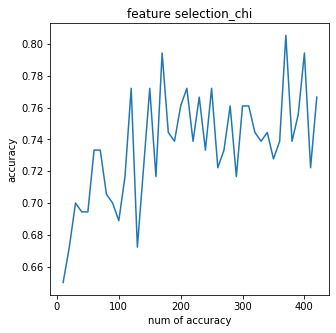

In [28]:
mean_chi = []
std_chi = []
features = range(10,430,10)
for i in features:
    X_fschi = SelectKBest(chi2, k=i).fit_transform(X, y)
    logo = LeaveOneGroupOut()
    for train, test in logo.split(X_fschi, y, groups=group):
        X_train, X_test = X_fschi[train], X_fschi[test]
        y_train, y_test = y[train], y[test]
        #clf_svcl = SVC(kernel='linear').fit(X_train, y_train)
        clf_rfc=RFC(n_estimators=10,random_state=0)
    score = Logo(X_fschi, y, clf_rfc)
    std = Logostd(X_fschi, y, clf_rfc)  
    mean_chi.append(score)
    std_chi.append(std)

fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(1,1,1)
ax.set_title("feature selection_chi")
ax.set_xlabel('num of accuracy')
ax.set_ylabel('accuracy')
ax.plot(features,mean_chi)
print(max(mean_chi), features[mean_chi.index(max(mean_chi))])
#print(min(stdscore), features[stdscore.index(min(stdscore))])

In [36]:
X_fschi = SelectKBest(chi2, k=370).fit_transform(X, y) 

In [37]:
X_fschi.shape

(180, 370)

In [111]:
X_fschi = SelectKBest(chi2, k=370).fit_transform(X, y) 
y_predict = []
for train, test in logo.split(X_fschi, y, groups=group):
    X_train, X_test = X_fschi[train], X_fschi[test]
    y_train, y_test = y[train], y[test]
    clf_rfc=RFC(n_estimators=10,random_state=0).fit(X_train, y_train)
    #clf_svcl = SVC(kernel='linear').fit(X_train, y_train)
    y_predl = clf_rfc.predict(X_test)
    y_predict.append(y_predl)
    
tp = np.sum(y_predict[10:])
fp = np.sum(y_predict[:10])
tn = 100 - fp
fn = 80 - tp

acc = (tp+tn)/(tp+tn+fp+fn)                #accuracy
pvv = tp/(tp+fp)                           #precision
tpr = tp/(tp+fn)                           #sensitivity
tnr = tn/(tn+fp)                           #specificity

chirfc = Logo(X_fschi, y, clf_svcl)
stdscore = Logostd(X_fschi, y, clf_svcl)
print("Mean score is %s" %chirfc)
print("The standard deviation is %s" %stdscore)
print("Accuracy=%s" % acc)
print("Precision=%s" % pvv)
print("Sensitivity=%s" % tpr)
print("Specificity=%s" % tnr)

Mean score is 0.8666666666666667
The standard deviation is 0.1084652289093281
Accuracy=0.8055555555555556
Precision=0.8169014084507042
Sensitivity=0.725
Specificity=0.87


In [ ]:
# Logistic Regression and chi

0.8277777777777778 4.170707070707071
0.8777777777777778 5.979797979797979


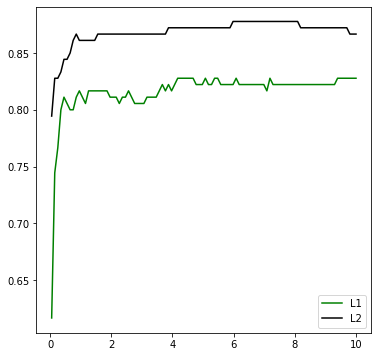

In [159]:
l1 = []
l2 = []
c = np.linspace(0.05,10,100)
for i in c:
    lrl1 = LR(penalty="l1", solver="liblinear", C=i, max_iter=1000)
    lrl2 = LR(penalty="l2", solver="liblinear", C=i, max_iter=1000)
    for train, test in logo.split(X, y, groups=group):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        lrl1 = lrl1.fit(X_train,y_train)
        lrl2 = lrl2.fit(X_train,y_train)
    l1.append(Logo(X, y, lrl1))
    l2.append(Logo(X, y, lrl2))

graph = [l1,l2]
color = ["green","black"]
label = ["L1","L2"]

plt.figure(figsize=(6,6))
for i in range(len(graph)):
    plt.plot(c,graph[i],color[i],label=label[i]) 
plt.legend(loc="best") 
print(max(l1), c[l1.index(max(l1))])
print(max(l2), c[l2.index(max(l2))])

we use l2 as penalty for logistic model here ; the highest l2 score is 0.8777 at 5.98
the highest l1 score is 0.8278 at 4.171(we will use l1 as embedded method for feature selection later)

0.8833333333333333 330


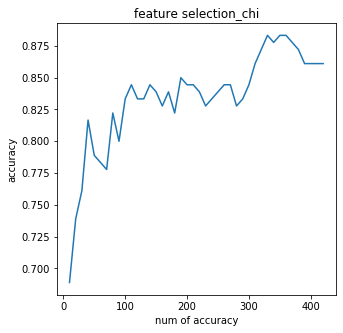

In [161]:
mean_chi = []
std_chi = []
features = range(10,430,10)
for i in features:
    X_fschi = SelectKBest(chi2, k=i).fit_transform(X, y)
    logo = LeaveOneGroupOut()
    for train, test in logo.split(X_fschi, y, groups=group):
        X_train, X_test = X_fschi[train], X_fschi[test]
        y_train, y_test = y[train], y[test]
        #clf_svcl = SVC(kernel='linear').fit(X_train, y_train)
        #clf_rfc=RFC(n_estimators=10,random_state=0)
        clf_lr = LR(solver="liblinear", C=5.98, random_state=400) #for l1
    score = Logo(X_fschi, y, clf_lr)
    std = Logostd(X_fschi, y, clf_lr)  
    mean_chi.append(score)
    std_chi.append(std)

fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(1,1,1)
ax.set_title("feature selection_chi")
ax.set_xlabel('num of accuracy')
ax.set_ylabel('accuracy')
ax.plot(features,mean_chi)
print(max(mean_chi), features[mean_chi.index(max(mean_chi))])
#print(min(stdscore), features[stdscore.index(min(stdscore))])

In [162]:
X_fschi = SelectKBest(chi2, k=330).fit_transform(X, y) 

In [164]:
X_fschi = SelectKBest(chi2, k=330).fit_transform(X, y) 
y_predict = []
for train, test in logo.split(X_fschi, y, groups=group):
    X_train, X_test = X_fschi[train], X_fschi[test]
    y_train, y_test = y[train], y[test]
    #clf_rfc=RFC(n_estimators=10,random_state=0).fit(X_train, y_train)
    #clf_svcl = SVC(kernel='linear').fit(X_train, y_train)
    clf_lr = LR(solver="liblinear", C=5.98, random_state=400).fit(X_train, y_train)
    y_predl = clf_lr.predict(X_test)
    y_predict.append(y_predl)
    
tp = np.sum(y_predict[10:])
fp = np.sum(y_predict[:10])
tn = 100 - fp
fn = 80 - tp

acc = (tp+tn)/(tp+tn+fp+fn)                #accuracy
pvv = tp/(tp+fp)                           #precision
tpr = tp/(tp+fn)                           #sensitivity
tnr = tn/(tn+fp)                           #specificity

chilog = Logo(X_fschi, y, clf_lr)
stdscore = Logostd(X_fschi, y, clf_lr)
print("Mean score is %s" %chilog)
print("The standard deviation is %s" %stdscore)
print("Accuracy=%s" % acc)
print("Precision=%s" % pvv)
print("Sensitivity=%s" % tpr)
print("Specificity=%s" % tnr)
    
    
    


Mean score is 0.8833333333333333
The standard deviation is 0.08574929257125441
Accuracy=0.8833333333333333
Precision=0.8641975308641975
Sensitivity=0.875
Specificity=0.89


__conclusion__ for chi-square(filter) the SVC is best

__feature_selection.RFE__

__rfe and svc（wrapper）__

0.9944444444444444 111


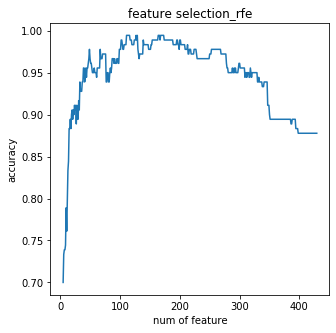

In [47]:
mscore = []
stdscore = []
nfea = range(5,430) 
for i in nfea:
    X_wrapper = RFE(clf_svcl,n_features_to_select=i, step=50).fit_transform(X,y)
    logo = LeaveOneGroupOut()
    for train, test in logo.split(X_wrapper, y, groups=group):
        X_train, X_test = X_wrapper[train], X_wrapper[test]
        y_train, y_test = y[train], y[test]
        #clf_svcl = SVC(kernel='linear').fit(X_train, y_train)
        #clf_rfc=RFC(n_estimators=10,random_state=0)
        #clf_lr = LR(solver="liblinear", C=0.84, random_state=400)
        clf_svcl = SVC(kernel='linear').fit(X_train, y_train)
    oncesm = Logo(X_wrapper, y, clf_svcl)
    oncess = Logostd(X_wrapper, y, clf_svcl)
    
    mscore.append(oncesm)
    stdscore.append(oncess)

fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(1,1,1)
ax.set_title("feature selection_rfe")
ax.set_xlabel('num of feature')
ax.set_ylabel('accuracy')
ax.plot(nfea,mscore)
#ax2 = fig.add_subplot(3,1,3)
#ax2.set_title("Standard Deviation")
#ax2.set_xlabel('feature number')
#ax2.set_ylabel('std')
#ax2.plot(nfea,stdscore)

print(max(mscore), nfea[mscore.index(max(mscore))])
#print(min(stdscore), nfea[stdscore.index(min(stdscore))])

In [119]:
selector = RFE(clf_svcl, n_features_to_select=111, step=50).fit(X, y)
selector.support_.sum()
selector.ranking_
X_wrapper = selector.transform(X)

y_predict = []
for train, test in logo.split(X_wrapper, y, groups=group):
    X_train, X_test = X_wrapper[train], X_wrapper[test]
    y_train, y_test = y[train], y[test]
    clf_svcl = SVC(kernel='linear').fit(X_train, y_train)
    y_predl = clf_svcl.predict(X_test)
    y_predict.append(y_predl)
    
tp = np.sum(y_predict[10:])
fp = np.sum(y_predict[:10])
tn = 100 - fp
fn = 80 - tp

acc = (tp+tn)/(tp+tn+fp+fn)                #accuracy
pvv = tp/(tp+fp)                           #precision
tpr = tp/(tp+fn)                           #sensitivity
tnr = tn/(tn+fp)                           #specificity

rfesvc = Logo(X_wrapper, y, clf_svcl)
stdscore = Logostd(X_wrapper, y, clf_svcl)
print("Mean score is %s" %rfesvc)
print("The standard score is %s" %stdscore)
print("Accuracy=%s" % acc)
print("Precision=%s" % pvv)
print("Sensitivity=%s" % tpr)
print("Specificity=%s" % tnr)

Mean score is 0.9944444444444444
The standard score is 0.023570226039551577
Accuracy=0.9944444444444445
Precision=0.9876543209876543
Sensitivity=1.0
Specificity=0.99


__rfe and logistic__

0.9166666666666666 30


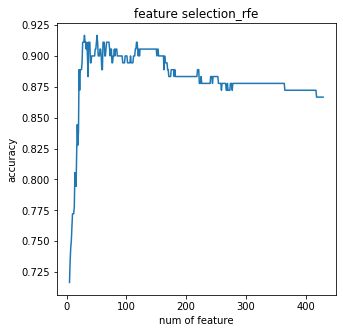

In [169]:
mscore = []
stdscore = []
nfea = range(5,430) 
for i in nfea:
    X_wrapper = RFE(clf_lr,n_features_to_select=i, step=50).fit_transform(X,y)
    logo = LeaveOneGroupOut()
    for train, test in logo.split(X_wrapper, y, groups=group):
        X_train, X_test = X_wrapper[train], X_wrapper[test]
        y_train, y_test = y[train], y[test]
        #clf_svcl = SVC(kernel='linear').fit(X_train, y_train)
        #clf_rfc=RFC(n_estimators=10,random_state=0)
        clf_lr = LR(solver="liblinear", C=5.98, random_state=400).fit(X_train, y_train)
        #clf_svcl = SVC(kernel='linear').fit(X_train, y_train)
    oncesm = Logo(X_wrapper, y, clf_lr)
    oncess = Logostd(X_wrapper, y, clf_lr)
    
    mscore.append(oncesm)
    stdscore.append(oncess)

fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(1,1,1)
ax.set_title("feature selection_rfe")
ax.set_xlabel('num of feature')
ax.set_ylabel('accuracy')
ax.plot(nfea,mscore)
#ax2 = fig.add_subplot(3,1,3)
#ax2.set_title("Standard Deviation")
#ax2.set_xlabel('feature number')
#ax2.set_ylabel('std')
#ax2.plot(nfea,stdscore)

print(max(mscore), nfea[mscore.index(max(mscore))])
#print(min(stdscore), nfea[stdscore.index(min(stdscore))])

In [170]:
selector = RFE(clf_lr, n_features_to_select=30, step=50).fit(X, y)
selector.support_.sum()
selector.ranking_
X_wrapper = selector.transform(X)

y_predict = []
for train, test in logo.split(X_wrapper, y, groups=group):
    X_train, X_test = X_wrapper[train], X_wrapper[test]
    y_train, y_test = y[train], y[test]
    clf_lr = LR(solver="liblinear", C=5.98, random_state=400).fit(X_train, y_train)
    y_predl = clf_lr.predict(X_test)
    y_predict.append(y_predl)
    
tp = np.sum(y_predict[10:])
fp = np.sum(y_predict[:10])
tn = 100 - fp
fn = 80 - tp

acc = (tp+tn)/(tp+tn+fp+fn)                #accuracy
pvv = tp/(tp+fp)                           #precision
tpr = tp/(tp+fn)                           #sensitivity
tnr = tn/(tn+fp)                           #specificity

rfelog = Logo(X_wrapper, y, clf_svcl)
stdscore = Logostd(X_wrapper, y, clf_svcl)
print("Mean score is %s" %rfelog)
print("The standard score is %s" %stdscore)
print("Accuracy=%s" % acc)
print("Precision=%s" % pvv)
print("Sensitivity=%s" % tpr)
print("Specificity=%s" % tnr)

Mean score is 0.9333333333333333
The standard score is 0.08401680504168059
Accuracy=0.9166666666666666
Precision=0.9012345679012346
Sensitivity=0.9125
Specificity=0.92


__rfe and random forest__

0.838888888888889 149


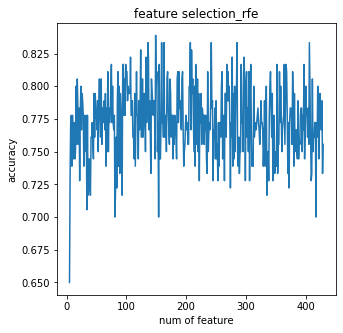

In [54]:
mscore = []
stdscore = []
nfea = range(5,430) 
for i in nfea:
    X_wrapper = RFE(clf_rfc,n_features_to_select=i, step=50).fit_transform(X,y)
    logo = LeaveOneGroupOut()
    for train, test in logo.split(X_wrapper, y, groups=group):
        X_train, X_test = X_wrapper[train], X_wrapper[test]
        y_train, y_test = y[train], y[test]
        #clf_svcl = SVC(kernel='linear').fit(X_train, y_train)
        clf_rfc=RFC(n_estimators=10,random_state=0)
        #clf_lr = LR(solver="liblinear", C=5.98, random_state=400).fit(X_train, y_train)
        #clf_svcl = SVC(kernel='linear').fit(X_train, y_train)
    oncesm = Logo(X_wrapper, y, clf_rfc)
    oncess = Logostd(X_wrapper, y, clf_rfc)
    
    mscore.append(oncesm)
    stdscore.append(oncess)

fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(1,1,1)
ax.set_title("feature selection_rfe")
ax.set_xlabel('num of feature')
ax.set_ylabel('accuracy')
ax.plot(nfea,mscore)
#ax2 = fig.add_subplot(3,1,3)
#ax2.set_title("Standard Deviation")
#ax2.set_xlabel('feature number')
#ax2.set_ylabel('std')
#ax2.plot(nfea,stdscore)

print(max(mscore), nfea[mscore.index(max(mscore))])
#print(min(stdscore), nfea[stdscore.index(min(stdscore))])

In [121]:
selector = RFE(clf_rfc, n_features_to_select=149, step=50).fit(X, y)
selector.support_.sum()
selector.ranking_
X_wrapper = selector.transform(X)

y_predict = []
for train, test in logo.split(X_wrapper, y, groups=group):
    X_train, X_test = X_wrapper[train], X_wrapper[test]
    y_train, y_test = y[train], y[test]
    clf_rfc = clf_rfc=RFC(n_estimators=10,random_state=0).fit(X_train, y_train)
    y_predl = clf_rfc.predict(X_test)
    y_predict.append(y_predl)
    
tp = np.sum(y_predict[10:])
fp = np.sum(y_predict[:10])
tn = 100 - fp
fn = 80 - tp

acc = (tp+tn)/(tp+tn+fp+fn)               #accuracy
pvv = tp/(tp+fp)                          #precision
tpr = tp/(tp+fn)                           #sensitivity
tnr = tn/(tn+fp)                           #specificity

rferfc = Logo(X_wrapper, y, clf_svcl)
stdscore = Logostd(X_wrapper, y, clf_svcl)
print("Mean score is %s" %rferfc)
print("The standard score is %s" %stdscore)
print("Accuracy=%s" % acc)
print("Precision=%s" % pvv)
print("Sensitivity=%s" % tpr)
print("Specificity=%s" % tnr)

Mean score is 0.8333333333333334
The standard score is 0.1414213562373095
Accuracy=0.7444444444444445
Precision=0.7575757575757576
Sensitivity=0.625
Specificity=0.84


__embedded method__

for this part we use l1 for feature selection
reference:https://scikit-learn.org/stable/modules/feature_selection.html

In [17]:
LR_e = LR(solver="liblinear",penalty="l1", C=4.17, random_state=400)
X_embedded = SelectFromModel(LR_e, norm_order=1).fit_transform(X, y) #lasso
y_predict = []
for train, test in logo.split(X_embedded, y, groups=group):
    X_train, X_test = X_embedded[train], X_embedded[test]
    y_train, y_test = y[train], y[test]
    LR_e = LR(solver="liblinear", penalty="l1",C=4.17, random_state=400).fit(X_train,y_train)
    y_predl = LR_e.predict(X_test)
    y_predict.append(y_predl)

tp = np.sum(y_predict[10:])
fp = np.sum(y_predict[:10])
tn = 100 - fp
fn = 80 - tp

acc = (tp+tn)/(tp+tn+fp+fn)                #accuracy
pvv = tp/(tp+fp)                           #precision
tpr = tp/(tp+fn)                           #sensitivity
tnr = tn/(tn+fp)                           #specificity

emblog = Logo(X_embedded, y, LR_e)
stdscore = Logostd(X_embedded, y, LR_e)
print("Mean score is %s" %emblog)
print("The standard score is %s" %stdscore)
print("Accuracy=%s" % acc)
print("Precision=%s" % pvv)
print("Sensitivity=%s" % tpr)
print("Specificity=%s" % tnr)

Mean score is 0.8444444444444446
The standard score is 0.0783823376129674
Accuracy=0.8444444444444444
Precision=0.825
Sensitivity=0.825
Specificity=0.86


In [18]:
X_embedded.shape

(180, 57)

__comparison__

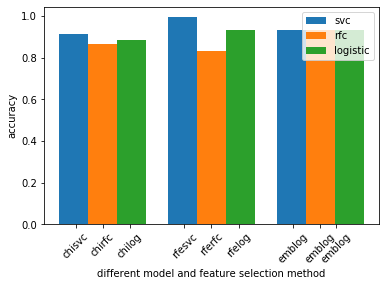

In [175]:
import numpy as np
import matplotlib.pyplot as plt

size = 3
x = np.arange(size)
a = [chisvc,rfesvc,emblog]
b = [chirfc,rferfc,emblog]
c = [chilog,rfelog,emblog]
#c = [emblog]

total_width, n = 0.8, 3
width = total_width / n
x = x - (total_width - width) / 2

plt.bar(x, a,  width=width, label='svc')
plt.bar(x + width, b, width=width, label='rfc')
plt.bar(x + 2 * width, c, width=width, label='logistic')

t=[-0.25,0.00,0.25,0.75,1.00,1.25,1.75,2,2.15]
names = ['chisvc', 'chirfc', 'chilog', 'rfesvc', 'rferfc','rfelog','emblog','emblog','emblog']
plt.xticks(t, names, rotation=45)
plt.xlabel("different model and feature selection method")
plt.ylabel("accuracy")
plt.legend()
plt.savefig('compare.png')
plt.show()

#for the embedded method ,only use logistic model, in the picture,repeat it 3 times